# Sector Coupling

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).
Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install -q pypsa pandas numpy matplotlib highspy "plotly<6"
```
:::

In [129]:
import pypsa
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.offline as py
import matplotlib.pyplot as plt
from pypsa.common import annuity
pd.options.plotting.backend = "plotly"

## Previously

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top. 

Some of the sector-coupling technologies we are going to add have multiple ouputs (e.g. CHP plants producing heat and power). PyPSA can automatically handle links have more than one input (`bus0`)
and/or output (i.e. `bus1`, `bus2`, `bus3`) with a given efficieny (`efficiency`, `efficiency2`, `efficiency3`).

In [130]:
url = "https://tubcloud.tu-berlin.de/s/Rz4iDEQq8DwBd6R/download/electricity-network.nc"
n = pypsa.Network(url)

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, loads, storage_units, sub_networks


In [131]:
n

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 3
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
 - SubNetwork: 1
Snapshots: 2920

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [132]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [133]:
n.add("Bus", "hydrogen", carrier='hydrogen');

Add a `Link` for the hydrogen electrolysis:

In [134]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=0.65,
    capital_cost=annuity(0.07, 25) * 1_500_000, # €/MW/a
)

Index(['electrolysis'], dtype='object')

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [135]:
n.add(
    "Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier="fuel cell",
    p_nom_extendable=True,
    efficiency=0.45,
    capital_cost=annuity(0.07, 25) * 550_000, # €/MW/a
);

Add a `Store` for the hydrogen storage:

In [136]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=annuity(0.07, 100) * 2_000,  # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True,  # cyclic state of charge
);

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [137]:
p_set = n.loads_t.p_set["demand"].mean()
p_set

np.float64(7564.622045662099)

In [138]:
n.add("Load", "hydrogen demand", bus="hydrogen", carrier="hydrogen", p_set=p_set);  # MW

Add new `Carrier` extensions (only used for plotting):

In [139]:
n.add(
    "Carrier",
    ["hydrogen", "electrolysis", "fuel cell", "hydrogen storage", "hydrogen demand"],
    color=["cyan", "magenta", "orange", "purple", "cyan"]
);

When we now optimize the model with additional hydrogen demand...

In [140]:
n.optimize(log_to_console=False)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 275.35it/s]
INFO:linopy.io: Writing time: 0.3s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29207 primals, 64248 duals
Objective: 1.24e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

...we can see the individual sizing of the electrolyser, fuel cell and hydrogen storage:

In [141]:
n.statistics.optimal_capacity().div(1e3).round(2)

component    carrier         
Generator    solar                 64.22
             wind                  58.56
Link         electrolysis          20.09
             fuel cell              9.50
StorageUnit  battery storage       13.85
Store        hydrogen storage    4596.07
dtype: float64

Furthermore, we might want to explore the storage state of charge of the hydrogen storage and the balancing patterns:

In [142]:
n.stores_t.e.div(1e6).plot() # TWh

The energy balance we can now inspect by different bus carriers:

In [143]:
n.statistics.energy_balance.iplot.area(bus_carrier="electricity")

In [144]:
n.statistics.energy_balance.iplot.area(bus_carrier="hydrogen")

## Heat Demand

For modelling simple heating systems, we create another bus and connect a load with the heat demand time series to it.

In [145]:
n.add("Bus", "heat", carrier='heat');

In [146]:
url = "https://tubcloud.tu-berlin.de/s/8KWqTAHEM9m8dFj/download/heat-demand.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [147]:
n.add("Load", "heat demand", carrier="heat", bus="heat", p_set=p_set);

In [148]:
n.loads_t.p_set.div(1e3).plot()

What is now missing are a few heat supply options...

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is assumed to be given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [149]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [150]:
url = "https://tubcloud.tu-berlin.de/s/Ym7Gzozw7pjYzNz/download/temperature.csv"
temp = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [151]:
cop(temp).plot()

Text(0, 0.5, 'COP [-]')

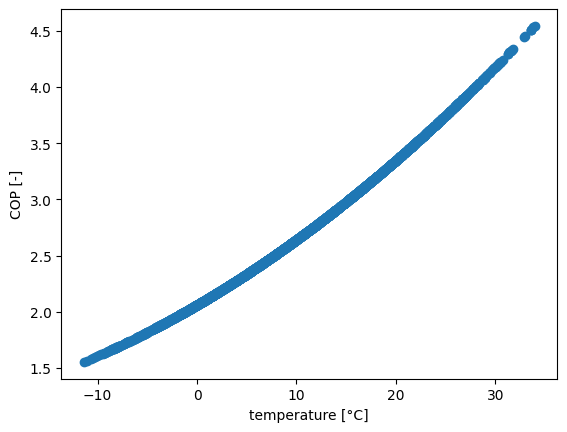

In [152]:
plt.scatter(temp, cop(temp))
plt.xlabel("temperature [°C]")
plt.ylabel("COP [-]")

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [153]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=annuity(0.05, 18) * 280_000,  # €/MWe/a
);

Let's also add a resistive heater as backup technology:

In [154]:
n.add(
    "Link",
    "resistive heater",
    carrier="resistive heater",
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=annuity(0.05, 20) * 120_000,  # €/MWe/a
    p_nom_extendable=True,
);

In [155]:
n.add(
    "Carrier",
    ["heat", "heat demand", "heat pump", "resistive heater"],
    color=["firebrick", "firebrick", "lime", "khaki"]
);

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume imported green methane or methanol with relatively high marginal costs. Since, in that case, we have no other net emission technology, we can remove the CO$_2$ limit.

In [156]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [157]:
n.add("Bus", "gas", carrier="gas");

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 180 €/MWh.

In [158]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6,  # MWh
    e_nom=100e6,  # MWh
    bus="gas",
    marginal_cost=150,  # €/MWh_th
);

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [159]:
n.remove("Generator", "OCGT")

In [160]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=annuity(0.07, 25) * 450_000,  # €/MW_th/a
    efficiency=0.4,
);

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation).

In [161]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=annuity(0.07, 25) * 600_000,
    efficiency=0.4,
    efficiency2=0.4,
);

And we should not forget to add the carriers for plotting:

In [162]:
n.add(
    "Carrier",
    ["gas", "gas storage", "CHP"],
    color=["peru", "tan", "sienna"]
);

Now, let's optimize the current status of model:

In [163]:
n.optimize(log_to_console=False)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 209.14it/s]
INFO:linopy.io: Writing time: 0.37s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43810 primals, 96370 duals
Objective: 1.65e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, let's optimize the current status of model:

The objective cost in bn€/a:

In [164]:
n.objective / 1e9

16.457437155719962

The heat energy balance (positive is supply, negative is consumption):

In [165]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier    bus_carrier
Link       heat pump  heat           62.1
           CHP        heat            3.6
Load       heat       heat          -65.7
dtype: float64

In [166]:
n.statistics.energy_balance(bus_carrier='electricity').sort_values().div(1e6).round(1)

component    carrier          bus_carrier
Link         electrolysis     electricity   -102.4
Load         -                electricity    -66.3
Link         heat pump        electricity    -28.7
StorageUnit  battery storage  electricity     -1.2
Link         fuel cell        electricity      0.1
             CHP              electricity      3.6
Generator    solar            electricity     69.7
             wind             electricity    125.2
dtype: float64

The heat energy balance as a time series:

In [167]:
n.statistics.energy_balance.iplot.area(bus_carrier='heat')

In [168]:
n.statistics.energy_balance.iplot.area(bus_carrier='electricity')

## Long-duration heat storage

One technology of particular interest in district heating systems with large shares of renewables is long-duration thermal energy storage.

In the following, we are going to introduce a heat storage with investment cost of approximately 3 €/kWh.
The energy is not perfectly stored in water tanks. There are standing losses.
The decay of thermal energy in the heat storage is modelled through the function $1 - e^{-\frac{1}{24\tau}}$, where $\tau$ is assumed to be 180 days.
We want to see how that influences the optimal design decisions in the heating sector.

In [ ]:
n.add(
    "Store",
    "heat storage",
    bus="heat",
    carrier="heat storage",
    capital_cost=300, # roughly annuity of 3 €/kWh/a
    standing_loss=1 - np.exp(-1 / 24 / 180),
    e_nom_extendable=True,
);

In [ ]:
n.add("Carrier", "heat storage", color="teal");

Index(['heat storage'], dtype='object')

In [170]:
n.optimize(log_to_console=False)

Index(['heat storage'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 186.84it/s]
INFO:linopy.io: Writing time: 0.44s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 49651 primals, 105131 duals
Objective: 1.46e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

The objective cost (in bn€/a) was reduced!

In [171]:
n.objective / 1e9

14.627672117694456

The heat energy balance shows the additional losses of the heat storage and the added supply:

In [173]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier       bus_carrier
Link       heat pump     heat           66.1
           CHP           heat            1.0
Load       heat          heat          -65.7
Store      heat storage  heat           -1.3
dtype: float64

In [174]:
n.statistics.energy_balance(bus_carrier='electricity').div(1e6).round(1)

component    carrier          bus_carrier
Generator    solar            electricity     63.4
             wind             electricity    133.2
Link         electrolysis     electricity   -103.0
             heat pump        electricity    -27.9
             CHP              electricity      1.0
             fuel cell        electricity      0.3
Load         -                electricity    -66.3
StorageUnit  battery storage  electricity     -0.7
dtype: float64

The heat and electricity energy balance as a time series:

In [179]:
n.statistics.energy_balance.iplot.area(bus_carrier='heat')

In [181]:
n.statistics.energy_balance.iplot.area(bus_carrier='electricity')

The different storage state of charge time series:

In [184]:
n.stores_t.e.drop("gas storage", axis=1).plot()

And it can tell you statistics about the capital expenditures:

In [185]:
n.statistics.capex.iplot()

And it can tell you statistics about the operational expenditures:

In [186]:
n.statistics.opex.iplot()

## Exercises

Explore how the model reacts to changing assumptions and available technologies. Here are a few inspirations, but choose in any order according to your interests:

- Assume underground hydrogen storage is not geographically available. Increase the cost of hydrogen storage by factor 10. How does the model react?
- Add a ground-sourced heat pump with a constant COP function of 3.5 but double the investment costs. Would this technology get built? How low would the costs need to be?
- Limit green gas imports to 10 TWh or even zero. What does the model do in periods with persistent low wind and solar feed-in but high heating demand?